# Draft Model

In [1]:
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import requests

In [2]:
ADP_URL = "https://www.fantasypros.com/nfl/adp/ppr-overall.php"

In [3]:
def make_adp_df():
    res = requests.get(ADP_URL)
    if res.ok:
        soup = BS(res.content, 'html.parser')
        table = soup.find('table', {'id':'data'})
        df = pd.read_html(str(table))[0]
        print('Output after reading the html:\n\n',df.head(),'\n')
        df = df[['Player Team (Bye)','POS','AVG']]
        print('Output after filtering:\n\n',df.head(),'\n')
        df['PLAYER'] = df['Player Team (Bye)'].apply(lambda x:' '.join(x.split()[:-2]))
        df['POS'] = df['POS'].apply(lambda x:x[:2])
        
        df = df[['PLAYER','POS','AVG']].sort_values(by='AVG')
        
        print('Final output:\n\n', df.head())
        
        return df
    
    else:
        print("Didn't work, try again")

In [4]:
df = make_adp_df()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      3.0  3.0
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       4.0      6.0  4.7
4     5         Michael Thomas NO (6)  WR1   6.0  NaN       5.0      4.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.0
3           Dalvin Cook MIN (7)  RB4  4.7
4         Michael Thomas NO (6)  WR1  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.0
3          Dalvin Cook  RB  4.7
4       Michael Thomas  WR  5.0


In [5]:
df.head()

,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.0
3,Dalvin Cook,RB,4.7
4,Michael Thomas,WR,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 596
Data columns (total 3 columns):
PLAYER    597 non-null object
POS       597 non-null object
AVG       597 non-null float64
dtypes: float64(1), object(2)
memory usage: 18.7+ KB


In [7]:
replacement_players = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

In [8]:
replacement_players

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [9]:
# look at the top 100 picks in our df and get the last RB, WR, QB, and TE
# and store them in our dict

for _, row in df[:100].iterrows():
    position = row['POS']
    player = row['PLAYER']
    replacement_players[position] = player
    
replacement_players

{'RB': 'Matt Breida',
 'WR': 'Sterling Shepard',
 'TE': 'Jared Cook',
 'QB': 'Carson Wentz'}

Get projected player scores

In [10]:
BASE_URL = 'https://www.fantasypros.com/nfl/projections/{position}.php?week=draft'

def make_projection_df():
    
    final_df = pd.DataFrame()
    
    for position in ['rb', 'qb', 'te', 'wr']:
        
        res = requests.get(BASE_URL.format(position=position))
        if res.ok:
            soup = BS(res.content, 'html.parser')
            table = soup.find('table', {'id': 'data'})
            df = pd.read_html(str(table))[0]
            
            df.columns = df.columns.droplevel(level=0)
            df['PLAYER'] = df['Player'].apply(lambda x: ' '.join(x.split()[:-1]))
            if 'REC' in df.columns:
                df['FPTS'] = df['FPTS'] + df['REC']
                
            df['POS'] = position.upper()
            
            df = df[['PLAYER', 'POS', 'FPTS']]
            final_df = pd.concat([final_df, df])
            
        else:
            print("Didn't work, try again")
            return
    
    final_df = final_df.sort_values(by='FPTS', ascending=False)
    
    return final_df

In [11]:
df = make_projection_df()
df.head()

,PLAYER,POS,FPTS
0,Christian McCaffrey,RB,375.0
0,Lamar Jackson,QB,361.0
1,Patrick Mahomes,QB,344.9
0,Michael Thomas,WR,337.7
2,Dak Prescott,QB,318.4


Calculate replacement values

In [12]:
replacement_values = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

replacement_values

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [13]:
for position, player in replacement_players.items():
    if position in ['QB','TE', 'WR', 'RB']:
        replacement_values[position] = df.loc[df['PLAYER'] == player].values[0,-1]
        
replacement_values

{'RB': 138.3, 'WR': 183.8, 'TE': 151.10000000000002, 'QB': 274.5}

In [14]:
df['VOR'] = df.apply(
    lambda row: row['FPTS'] - replacement_values.get(row['POS']), 
    axis=1
)
df.head()

,PLAYER,POS,FPTS,VOR
0,Christian McCaffrey,RB,375.0,236.7
0,Lamar Jackson,QB,361.0,86.5
1,Patrick Mahomes,QB,344.9,70.4
0,Michael Thomas,WR,337.7,153.9
2,Dak Prescott,QB,318.4,43.9


In [15]:
df = df.sort_values(by='VOR', ascending=False)
df['VALUERANK'] = df['VOR'].rank(ascending=False)
df.head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK
0,Christian McCaffrey,RB,375.0,236.7,1.0
1,Saquon Barkley,RB,310.7,172.4,2.0
2,Ezekiel Elliott,RB,303.5,165.2,3.0
5,Alvin Kamara,RB,298.2,159.9,4.0
0,Michael Thomas,WR,337.7,153.9,5.0
4,Dalvin Cook,RB,289.9,151.6,6.0
3,Derrick Henry,RB,261.6,123.3,7.0
1,Davante Adams,WR,302.8,119.0,8.0
6,Clyde Edwards-Helaire,RB,254.3,116.0,9.0
13,Austin Ekeler,RB,252.6,114.3,10.0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

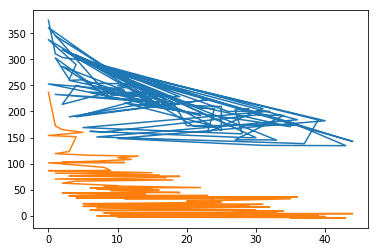

In [17]:
df.FPTS[:100].plot()
df.VOR[:100].plot()

In [18]:
# fig = plt.figure(figsize=(10,8))

# sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == 'RB'])

# plt.show()

In [19]:
positions = list(set(df.POS.values))
positions

['RB', 'WR', 'TE', 'QB']

In [20]:
# for p in positions:
#     sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == p])
#     plt.title(p)
#     plt.show()

# Avg Draft Pick

In [21]:
adp_df = make_adp_df()
adp_df.head()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      3.0  3.0
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       4.0      6.0  4.7
4     5         Michael Thomas NO (6)  WR1   6.0  NaN       5.0      4.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.0
3           Dalvin Cook MIN (7)  RB4  4.7
4         Michael Thomas NO (6)  WR1  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.0
3          Dalvin Cook  RB  4.7
4       Michael Thomas  WR  5.0


,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.0
3,Dalvin Cook,RB,4.7
4,Michael Thomas,WR,5.0


In [22]:
adp_df['ADPRANK'] = adp_df['AVG'].rank(method='first')

adp_df.head()

,PLAYER,POS,AVG,ADPRANK
0,Christian McCaffrey,RB,1.0,1.0
1,Saquon Barkley,RB,2.0,2.0
2,Ezekiel Elliott,RB,3.0,3.0
3,Dalvin Cook,RB,4.7,4.0
4,Michael Thomas,WR,5.0,5.0


Merge dataframes

In [23]:
df = df.merge(adp_df, how='left', on=['PLAYER', 'POS'])

df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0
2,Ezekiel Elliott,RB,303.5,165.2,3.0,3.0,3.0
3,Alvin Kamara,RB,298.2,159.9,4.0,5.3,6.0
4,Michael Thomas,WR,337.7,153.9,5.0,5.0,5.0


In [24]:
df.head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0
2,Ezekiel Elliott,RB,303.5,165.2,3.0,3.0,3.0
3,Alvin Kamara,RB,298.2,159.9,4.0,5.3,6.0
4,Michael Thomas,WR,337.7,153.9,5.0,5.0,5.0
5,Dalvin Cook,RB,289.9,151.6,6.0,4.7,4.0
6,Derrick Henry,RB,261.6,123.3,7.0,7.3,7.0
7,Davante Adams,WR,302.8,119.0,8.0,11.7,8.0
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0
9,Austin Ekeler,RB,252.6,114.3,10.0,15.0,14.0


In [25]:
df['SLEEPERSCORE'] = df['ADPRANK'] - df['VALUERANK']

df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0
2,Ezekiel Elliott,RB,303.5,165.2,3.0,3.0,3.0,0.0
3,Alvin Kamara,RB,298.2,159.9,4.0,5.3,6.0,2.0
4,Michael Thomas,WR,337.7,153.9,5.0,5.0,5.0,0.0


# Sleeper Score 

In [26]:
df.loc[df['AVG'] < 160].sort_values(by='SLEEPERSCORE', ascending=False).head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
33,Antonio Gibson,RB,192.3,54.0,34.0,131.3,129.0,95.0
124,Jonnu Smith,TE,130.1,-21.0,124.5,159.7,158.0,33.5
50,Tarik Cohen,RB,173.9,35.6,51.0,86.7,84.0,33.0
98,Duke Johnson,RB,134.4,-3.9,99.0,131.7,130.0,31.0
115,Ryan Tannehill,QB,258.3,-16.2,116.0,148.0,145.0,29.0
108,Jared Goff,QB,260.7,-13.8,109.0,140.0,137.0,28.0
119,Dallas Goedert,TE,132.3,-18.8,120.0,150.0,147.0,27.0
118,DeSean Jackson,WR,165.6,-18.2,119.0,146.3,144.0,25.0
62,Josh Allen,QB,297.6,23.1,63.0,89.7,88.0,25.0
101,Mike Gesicki,TE,146.0,-5.1,102.0,130.3,126.0,24.0


In [27]:
df.loc[df['AVG'] < 160].sort_values(by='SLEEPERSCORE', ascending=True).head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
320,Ke'Shawn Vaughn,RB,14.6,-123.7,321.5,154.3,152.0,-169.5
189,Mecole Hardman,WR,122.9,-60.9,190.0,134.7,134.0,-56.0
163,Alexander Mattison,RB,94.5,-43.8,164.0,126.3,122.0,-42.0
153,Justin Jefferson,WR,143.9,-39.9,154.0,121.3,118.0,-36.0
149,Jerry Jeudy,WR,148.3,-35.5,150.0,115.3,114.0,-36.0
120,J.K. Dobbins,RB,119.1,-19.2,121.0,90.7,89.0,-32.0
76,Leonard Fournette,RB,149.8,11.5,77.0,45.7,45.0,-32.0
111,Deebo Samuel,WR,168.7,-15.1,112.0,85.0,81.0,-31.0
107,Rob Gronkowski,TE,139.4,-11.7,108.0,82.0,78.0,-30.0
131,Emmanuel Sanders,WR,158.9,-24.9,132.0,107.0,103.0,-29.0


# Keeper Analysis

In [28]:
keepers_2020 = ['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
                'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
                'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
                'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
                'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
                'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
                'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
                'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
                'Michael Thomas', 'Patrick Mahomes', 'N/a ']

In [29]:
keeper_df = pd.read_excel('Keeper_Master Document.xlsx',sheet_name=None)

In [30]:
# keeper_df.keys()

In [31]:
# keeper_df['Keeper History'].head()

In [32]:
# keeper_history = keeper_df['Keeper History']
# keeper_history.head()

In [33]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [34]:
# keepers_2020

# Name Replacements

In [35]:
name_replacements = [('DJ Moore', 'D.J. Moore'),
 ('DJ Chark', 'D.J. Chark'),
 ('Juju Smith Schuster', 'JuJu Smith-Schuster'),
 ('JuJu Smith', 'JuJu Smith-Schuster'),
 ('DK Metcalf', 'D.K. Metcalf'),
 ('Brashad Perrimen', 'Breshad Perriman'),
 ('AJ Brown', 'A.J. Brown'),
 ('Ronald Jones', 'Ronald Jones II'),
 ('Ezekiel Elliot ', 'Ezekiel Elliott'),
 ('Ezekiel Elliot', 'Ezekiel Elliott'),
 ('Devante Parker ', 'DeVante Parker'),
 ('Devante Parker', 'DeVante Parker'),
 ('Saquon Barkely', 'Saquon Barkley'),
 ('Christian McAffrey', 'Christian McCaffrey'),
 ('Adam Thielan', 'Adam Thielen'),
 ('LeVeon Bell', "Le'Veon Bell"),
 ('Leornard Fournette', 'Leonard Fournette'),
 ('Mark Ingram', 'Mark Ingram II'),
 ('Mark Ingram ', 'Mark Ingram II'),
 ('TY Hilton', 'T.Y. Hilton'),
 ('Derius Guice', 'Derrius Guice'),
 ('AJ Green', 'A.J. Green'),
 ('Odell Beckham', 'Odell Beckham Jr.'),
 ('L McCoy', 'LeSean McCoy'),
 ('Alshon Jeffrey', 'Alshon Jeffery'),
 ('Marvin Jones Jr', 'Marvin Jones'),
 ('Darell Henderson', 'Darrell Henderson'),
 ('Russel Wilson', 'Russell Wilson'),
 ('A Miller', 'Anthony Miller'),
 ('DJ Metcalf', 'D.K. Metcalf'),
 ('Desean Jackson', 'DeSean Jackson'),
 ('Gio Bernard', 'Giovani Bernard'),
 ('Justice Mill', 'Justice Hill'),
 ('Kennan Ballage', 'Kalen Ballage'),
 ('Malcom Brown', 'Malcolm Brown'),
 ('Marques Valdez Scandling', 'Marquez Valdes-Scantling'),
 ('OJ Howard', 'O.J. Howard'),
 ('Philip Lindsay', 'Phillip Lindsay'),
 ('R Higgins', 'Rashard Higgins'),
 ('Rashad Penny', 'Rashaad Penny'),
 ('Tyreke Hill', 'Tyreek Hill'),
 ('TJ Hockenson', 'T.J. Hockenson')]

In [36]:
kickers = ['Greg Zuerlin',
 'Harrison Butker',
 'Justin Tucker',
 'Kai Fairbarn',
 'Mike Badgley',
 'Robbie Gould',
 'Stephen Gostowski',
 'Will Lutz',
 'Younghoe Koo',
 'Wil Lutz',
 'Austin Seibert']

In [37]:
defenses = ['Bears',
 'Rams',
 'Browns',
 'Eagles',
 'Jaguars',
 'Patriots',
 'Ravens',
 'Vikings',
 '49ers',
 'Broncos',
 'Chiefs',
 'Falcons',
 'Jets',
 'Pats']

In [38]:
unsigned_fa = ['Devonta Freeman',
 'Antonio Brown',
 'Derrius Guice',
 'Damien Williams',
 'Delanie Walker',
 'Geronimo Allison',
 'Josh Gordon',
 'Taylor Gabriel',
 'Tyrell Williams',
 'Adrian Peterson']

## Cleaning Keeper List

In [39]:
draft_19 = keeper_df['2019']

In [40]:
def check_names(check_list, correct_list):
    l = []
    for p in check_list:
        if p not in correct_list:
            l.append(p)
    return l

def find_name(name, source=df.PLAYER.values):
    for p in source:
        if name in p:
            print(p)
            
def name_replacer(wrong_name, correct_name, data=draft_19):
    data.replace(to_replace=wrong_name, value=correct_name, inplace=True)
    
def remove_fa_k_dst(main_list, fa, k, dst):
    main_list = np.setdiff1d(main_list, fa)
    main_list = np.setdiff1d(main_list, k)
    main_list = np.setdiff1d(main_list, dst)
    return main_list

In [41]:
keeper_replacements = [
    ('DJ Moore', 'D.J. Moore'), 
    ('DJ Chark', 'D.J. Chark'),
    ('Juju Smith Schuster', 'JuJu Smith-Schuster'),
    ('DK Metcalf', 'D.K. Metcalf'),
    ('Brashad Perrimen', 'Breshad Perriman'),
    ('AJ Brown', 'A.J. Brown'),
    ('Ronald Jones', 'Ronald Jones II'),
    ('Ezekiel Elliot ', 'Ezekiel Elliott'),
    ('Devante Parker ', 'DeVante Parker')
]

In [42]:
# for p in keeper_replacements:
#     keeper_history.replace(to_replace=p[0], value=p[1], inplace=True)

# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
    
# keepers_2020

In [43]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [44]:
keeper_list = list(keepers_2020)

In [45]:
# keepers cleaned
keepers_2020 = np.array(keeper_list)
keepers_2020

array(['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
       'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
       'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
       'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
       'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
       'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
       'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
       'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
       'Michael Thomas', 'Patrick Mahomes', 'N/a '], dtype='<U19')

# Last Year's Draft Picks

In [46]:
draft_19 = keeper_df['2019']

In [47]:
draft_19.columns[:8]

Index(['Tony', 'Mike', 'Joey', 'Vlad', 'Dave', 'Chris', 'Matt', 'Ben'], dtype='object')

In [48]:
draft_19.index[:18]

Index(['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6',
       'Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11', 'Round 12',
       'Round 13', 'Round 14', 'Round 15', 'Round 16', 'Round 17', 'Round 18'],
      dtype='object')

In [49]:
draft_19 = draft_19.iloc[:, :8]
draft_19

,Tony,Mike,Joey,Vlad,Dave,Chris,Matt,Ben
Round 1,Saquon Barkely,Ezekiel Elliot,Deshaun Watson,Julio Jones,Todd Gurley,Travis Kelce,Antonio Brown,Christian McAffrey
Round 2,Adam Thielan,Josh Jacobs,Amari Cooper,Chris Carson,Zach Ertz,Dalvin Cook,LeVeon Bell,Keenan Allen
Round 3,David Montgomery,Sony Michel,Leornard Fournette,Mike Williams,Mark Ingram,Melvin Gordon,Derrick Henry,Kenny Golladay
Round 4,Brandin Cooks,Kerryon Johnson,Stefon Diggs,Chris Godwin,DeAndre Hopkins,Julian Edelman,TY Hilton,Derius Guice
Round 5,Tevin Coleman,Mike Evans,Austin Ekeler,Evan Engram,Tyler Boyd,Calvin Ridley,AJ Green,Tyler Lockett
Round 6,Allen Robinson,Robert Woods,Tony Pollard,Devin Singletary,Christian Kirk,Odell Beckham,L McCoy,Miles Sanders
Round 7,Aaron Rodgers,Robby Anderson,Jarvis Landry,Baker Mayfield,Duke Johnson,Alshon Jeffrey,Courtland Sutton,Cam Newton
Round 8,Jordan Howard,Marvin Jones Jr,Sammy Watkins,Darell Henderson,Russel Wilson,Dede Westbrook,Kenyan Drake,Latavius Murray
Round 9,Matt Breida,Vance McDonald,James White,Larry Fitzgerald,Tarik Cohen,Greg Zuerlin,Emmanuel Sanders,Jared Cook
Round 10,Devonta Freeman,Curtis Samuel,Geronimo Allison,Rashad Penny,Justin Tucker,Mike Thomas,James Washington,Kyler Murray


In [50]:
all_players_19 = draft_19.values.flatten()

In [51]:
all_players_19

array(['Saquon Barkely', 'Ezekiel Elliot', 'Deshaun Watson',
       'Julio Jones', 'Todd Gurley', 'Travis Kelce', 'Antonio Brown',
       'Christian McAffrey', 'Adam Thielan', 'Josh Jacobs',
       'Amari Cooper', 'Chris Carson', 'Zach Ertz', 'Dalvin Cook',
       'LeVeon Bell', 'Keenan Allen', 'David Montgomery', 'Sony Michel',
       'Leornard Fournette', 'Mike Williams', 'Mark Ingram',
       'Melvin Gordon', 'Derrick Henry', 'Kenny Golladay',
       'Brandin Cooks', 'Kerryon Johnson', 'Stefon Diggs', 'Chris Godwin',
       'DeAndre Hopkins', 'Julian Edelman', 'TY Hilton', 'Derius Guice',
       'Tevin Coleman', 'Mike Evans', 'Austin Ekeler', 'Evan Engram',
       'Tyler Boyd', 'Calvin Ridley', 'AJ Green', 'Tyler Lockett',
       'Allen Robinson', 'Robert Woods', 'Tony Pollard',
       'Devin Singletary', 'Christian Kirk', 'Odell Beckham', 'L McCoy',
       'Miles Sanders', 'Aaron Rodgers', 'Robby Anderson',
       'Jarvis Landry', 'Baker Mayfield', 'Duke Johnson',
       'Alshon Je

In [52]:
names_to_fix = check_names(all_players_19, df.PLAYER.values)

In [53]:
len(names_to_fix)

138

In [54]:
# original_keepers = [p[0] for p in keeper_replacements]

# for p in original_keepers:
#     if p in names_to_fix:
#         print(p)

In [55]:
for p in name_replacements:
    draft_19.replace(to_replace=p[0], value=p[1], inplace=True)

all_players_19 = draft_19.values.flatten()
    
names_to_fix = check_names(all_players_19, df.PLAYER.values)
len(names_to_fix)

96

In [56]:
names_to_fix = remove_fa_k_dst(names_to_fix, unsigned_fa, kickers, defenses)
names_to_fix

array(['DeAndre Washington', 'Hakeem Butler', 'Kalen Ballage',
       'Trey Edmunds', 'nan'], dtype='<U18')

In [57]:
names_to_fix

array(['DeAndre Washington', 'Hakeem Butler', 'Kalen Ballage',
       'Trey Edmunds', 'nan'], dtype='<U18')

In [58]:
draft_19

,Tony,Mike,Joey,Vlad,Dave,Chris,Matt,Ben
Round 1,Saquon Barkley,Ezekiel Elliott,Deshaun Watson,Julio Jones,Todd Gurley,Travis Kelce,Antonio Brown,Christian McCaffrey
Round 2,Adam Thielen,Josh Jacobs,Amari Cooper,Chris Carson,Zach Ertz,Dalvin Cook,Le'Veon Bell,Keenan Allen
Round 3,David Montgomery,Sony Michel,Leonard Fournette,Mike Williams,Mark Ingram II,Melvin Gordon,Derrick Henry,Kenny Golladay
Round 4,Brandin Cooks,Kerryon Johnson,Stefon Diggs,Chris Godwin,DeAndre Hopkins,Julian Edelman,T.Y. Hilton,Derrius Guice
Round 5,Tevin Coleman,Mike Evans,Austin Ekeler,Evan Engram,Tyler Boyd,Calvin Ridley,A.J. Green,Tyler Lockett
Round 6,Allen Robinson,Robert Woods,Tony Pollard,Devin Singletary,Christian Kirk,Odell Beckham Jr.,LeSean McCoy,Miles Sanders
Round 7,Aaron Rodgers,Robby Anderson,Jarvis Landry,Baker Mayfield,Duke Johnson,Alshon Jeffery,Courtland Sutton,Cam Newton
Round 8,Jordan Howard,Marvin Jones,Sammy Watkins,Darrell Henderson,Russell Wilson,Dede Westbrook,Kenyan Drake,Latavius Murray
Round 9,Matt Breida,Vance McDonald,James White,Larry Fitzgerald,Tarik Cohen,Greg Zuerlin,Emmanuel Sanders,Jared Cook
Round 10,Devonta Freeman,Curtis Samuel,Geronimo Allison,Rashaad Penny,Justin Tucker,Mike Thomas,James Washington,Kyler Murray


# Keep Filtering

In [59]:
df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0
2,Ezekiel Elliott,RB,303.5,165.2,3.0,3.0,3.0,0.0
3,Alvin Kamara,RB,298.2,159.9,4.0,5.3,6.0,2.0
4,Michael Thomas,WR,337.7,153.9,5.0,5.0,5.0,0.0


In [60]:
keepers_2020

array(['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
       'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
       'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
       'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
       'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
       'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
       'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
       'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
       'Michael Thomas', 'Patrick Mahomes', 'N/a '], dtype='<U19')

In [61]:
df['KEEPER'] = df.PLAYER.isin(keepers_2020)
df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False
2,Ezekiel Elliott,RB,303.5,165.2,3.0,3.0,3.0,0.0,True
3,Alvin Kamara,RB,298.2,159.9,4.0,5.3,6.0,2.0,True
4,Michael Thomas,WR,337.7,153.9,5.0,5.0,5.0,0.0,True


## Begin df_no_keep

In [62]:
df_no_keep = df[df["KEEPER"] == False].copy()
df_no_keep

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False


## Add Keep Pick Eligibility

In [63]:
# keep_el = pd.read_excel('Keeper_Eligibility.xlsx', sheet_name=None)

In [64]:
# keep_el['penalty_keeps']

In [65]:
# keep_el['maintain_position']

In [66]:
# for p in name_replacements:
#     keep_el['penalty_keeps'].replace(to_replace=p[0], value=p[1], inplace=True)

In [67]:
# for p in name_replacements:
#     keep_el['maintain_position'].replace(to_replace=p[0], value=p[1], inplace=True)

In [68]:
# all_keeps = keep_el['maintain_position'].merge(keep_el['penalty_keeps'], on='PLAYER', how='outer')


In [69]:
# all_keeps['KEEPER'] = all_keeps.PLAYER.isin(keepers_2020)

In [70]:
# all_keeps = all_keeps[all_keeps['KEEPER'] == False]

In [71]:
# all_keeps

In [72]:
# merge1 = df_no_keep.merge(all_keeps,how='left', on='PLAYER')

In [73]:
# merge1

In [74]:
# merge1 = merge1.rename(columns={'KEEPER_y':'eligible'})

In [75]:
# merge2 = merge1.merge(keep_el['maintain_position'], how='inner', on='PLAYER')

In [76]:
pd.set_option('display.max_rows', None)

In [77]:
# merge2.drop(columns=['keep_eligibilty_x'], inplace=True)

In [78]:
# df_final = merge1.copy()

In [79]:
# df_final['VALUE_ROUND'] = (df_final['VALUERANK'] // 10) + 1 
# df_final

In [84]:
# df_final['keep_score'] = df_final['keep_eligibilty_x'] - df_final['VALUE_ROUND']
# df_final

# Final Keeper Analysis



In [85]:
# df_final.sort_values(by='SLEEPERSCORE', ascending=False)

In [86]:
# df_final.to_csv('position_analysis.csv')

# My Team

In [87]:
my_team = ['Saquon Barkley', 'Miles Sanders', 'David Johnson']

In [88]:
df_no_keep.head(30)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False


In [89]:
test_df = df_no_keep.copy()

In [90]:
test_df['available'] = True

In [91]:
test_df.loc[test_df['PLAYER'] == 'Christian McCaffrey', ['available']] = True

In [92]:
def avail_updtr(name, df=test_df, status=False):
    if name in df.PLAYER.values:
        df.loc[df['PLAYER'] == name, ['available']] = status
    else:
        print('incorrect name, try again')

In [93]:
avail_updtr('Christian McCaffrey', status=True)

In [94]:
test_df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False,True
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True


In [95]:
def best_avail(position=None, df=test_df, head_n=10):
    if position == None:
        df.sort_values(by="VALUERANK").head(head_n)
    elif position in ['RB','TE','WR','QB']:
        df[df['POS'] == position].sort_values(by="VALUERANK").head(head_n)
    else:
        print('incorrect postion value')

In [96]:
b = best_avail('RB')

In [97]:
b

In [98]:
test_df[test_df['POS'] == 'RB'].sort_values(by="VALUERANK").head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False,True
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False,True


In [99]:
test_df.head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False,True
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False,True
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False,True
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False,True
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False,True
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False,True


In [100]:
my_team

['Saquon Barkley', 'Miles Sanders', 'David Johnson']

In [101]:
my_test_team = ['Saquon Barkley', 'Miles Sanders', 'David Johnson', 
                'Dak Prescott','Keenan Allen','Adam Thielen',
                'Amari Cooper','Zach Ertz','Travis Kelce']

In [102]:
my_test_team

['Saquon Barkley',
 'Miles Sanders',
 'David Johnson',
 'Dak Prescott',
 'Keenan Allen',
 'Adam Thielen',
 'Amari Cooper',
 'Zach Ertz',
 'Travis Kelce']

In [103]:
team_roster = {
    'QB':None,
    'RB1':None,
    'RB2':None,
    'WR1':None,
    'WR2':None,
    'FLEX1':None,
    'FLEX2':None,
    'TE':None,
    'K':None,
    'DST':None,
    'Bench1':None,
    'Bench2':None,
    'Bench3':None,
    'Bench4':None,
    'Bench5':None,
    'Bench6':None,
    'Bench7':None,
    'Bench8':None,  
}

In [104]:
# determine player position
# top player in position = Pos1
# if RB or WR pos - second player in position = Pos2 
# all other players go to "yet to place pool"
# after players placed - top 2 WR/RB/TE become Flex1/Flex2
# finally all players are on bench

In [105]:
my_tm_df = df[df['PLAYER'].isin(my_test_team)]

In [106]:
my_tm_df

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False
26,David Johnson,RB,211.5,73.2,27.0,38.3,37.0,10.0,False
30,Zach Ertz,TE,213.6,62.5,31.0,38.3,38.0,7.0,False
38,Amari Cooper,WR,232.2,48.4,39.0,33.7,34.0,-5.0,False
40,Adam Thielen,WR,229.8,46.0,41.0,33.0,32.0,-9.0,False
41,Keenan Allen,WR,228.4,44.6,42.0,49.0,48.0,6.0,False
42,Dak Prescott,QB,318.4,43.9,43.0,53.7,52.0,9.0,False


In [107]:
def make_roster(team_members, df=my_tm_df, roster=team_roster):
    #place_later = []
    #place RBs 
    rbs = df[df['POS'] == 'RB'].sort_values(by='FPTS', ascending=False)
   
    team_roster['RB1'] = (rbs.iloc[0,0], rbs.iloc[0,2])
    
    team_roster['RB2'] = (rbs.iloc[1,0], rbs.iloc[1,2])
    
#     place_later = rbs.iloc[2:,0].values
    
    #place WRs 
    wrs = df[df['POS'] == 'WR'].sort_values(by='FPTS', ascending=False)
   
    team_roster['WR1'] = (wrs.iloc[0,0], wrs.iloc[0,2])
    
    team_roster['WR2'] = (wrs.iloc[1,0], wrs.iloc[1,2])
    
#     place_later = place_later + (wrs.iloc[2:,0].values)
    
    #place QBs 
    qbs = df[df['POS'] == 'QB'].sort_values(by='FPTS', ascending=False)
   
    team_roster['QB'] = (qbs.iloc[0,0], qbs.iloc[0,2])
    
#     place_later.append(qbs.iloc[1:,0].values)
#     place_later = place_later + (qbs.iloc[1:,0].values)
    
    #place TEs 
    tes = df[df['POS'] == 'TE'].sort_values(by='FPTS', ascending=False)
   
    team_roster['TE'] = (tes.iloc[0,0], tes.iloc[0,2])
    
#     place_later.append(tes.iloc[1:,0].values)
#     place_later = place_later + (tes.iloc[1:,0].values)
    
    place_later = (rbs.iloc[2:,0].values)+(wrs.iloc[2:,0].values)+(qbs.iloc[1:,0].values)+(tes.iloc[1:,0].values)
    display(place_later)
    #place Flex
#     flexs = df[df['PLAYER'].isin(place_later)].sort_values(by='FPTS',
#                                                            ascending=False)
# #     eligible_pos = ['RB','WR','TE']
    
# #     flexs = flexs[flexs['POS'].isin(eligible_pos)]
    
#     team_roster['FLEX1'] = (flexs.iloc[0,0], flexs.iloc[0,2])
    
#     team_roster['FLEX2'] = (flexs.iloc[1,0], flexs.iloc[1,2])

In [108]:
my_tm_df.iloc[2:,0].values

array(['Travis Kelce', 'David Johnson', 'Zach Ertz', 'Amari Cooper',
       'Adam Thielen', 'Keenan Allen', 'Dak Prescott'], dtype=object)

In [109]:
make_roster(my_team)

array([], dtype=object)

In [110]:
team_roster

{'QB': ('Dak Prescott', 318.4),
 'RB1': ('Saquon Barkley', 310.7),
 'RB2': ('Miles Sanders', 249.5),
 'WR1': ('Amari Cooper', 232.2),
 'WR2': ('Adam Thielen', 229.79999999999998),
 'FLEX1': None,
 'FLEX2': None,
 'TE': ('Travis Kelce', 252.7),
 'K': None,
 'DST': None,
 'Bench1': None,
 'Bench2': None,
 'Bench3': None,
 'Bench4': None,
 'Bench5': None,
 'Bench6': None,
 'Bench7': None,
 'Bench8': None}

In [111]:
test_df['val_rnd'] = (test_df['VALUERANK'] // 10) + 1 
test_df['adp_rnd'] = (test_df['ADPRANK'] // 10) + 1

# Work Area

In [112]:
draft_df = test_df.copy()

## My Team

In [151]:
my_team

['Saquon Barkley', 'Miles Sanders', 'David Johnson']

In [159]:
my_tm_df = draft_df[draft_df['PLAYER'].isin(my_team)]

In [160]:
my_tm_df

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False,False,1.0,1.0
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False,False,2.0,2.0
26,David Johnson,RB,211.5,73.2,27.0,38.3,37.0,10.0,False,False,3.0,4.0


In [152]:
for p in my_team:
    avail_updtr(p, df=draft_df)

In [153]:
draft_df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True,1.0,1.0
1,Saquon Barkley,RB,310.7,172.4,2.0,2.0,2.0,0.0,False,False,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True,1.0,2.0
10,Miles Sanders,RB,249.5,111.2,11.0,13.3,10.0,-1.0,False,False,2.0,2.0
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True,2.0,2.0


In [ ]:
find_name()

In [157]:
player = 'popcorn'

In [158]:
avail_updtr(player, df=draft_df)

incorrect name, try again


## All Top

In [154]:
test_df[test_df['available'] == True].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True,1.0,2.0
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True,2.0,2.0
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False,True,2.0,3.0
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False,True,2.0,2.0
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False,True,3.0,3.0
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False,True,3.0,1.0
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False,True,3.0,4.0
25,Chris Carson,RB,213.4,75.1,26.0,32.3,31.0,5.0,False,True,3.0,4.0
28,Melvin Gordon,RB,206.9,68.6,29.0,41.7,41.0,12.0,False,True,3.0,5.0


## Top RB

In [118]:
test_df[(test_df['available'] == True) & (test_df['POS'] == 'RB')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True,1.0,2.0
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False,True,2.0,2.0
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False,True,3.0,3.0
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False,True,3.0,4.0
25,Chris Carson,RB,213.4,75.1,26.0,32.3,31.0,5.0,False,True,3.0,4.0
28,Melvin Gordon,RB,206.9,68.6,29.0,41.7,41.0,12.0,False,True,3.0,5.0
33,Antonio Gibson,RB,192.3,54.0,34.0,131.3,129.0,95.0,False,True,4.0,13.0
49,Kareem Hunt,RB,174.5,36.2,50.0,61.7,65.0,15.0,False,True,6.0,7.0
50,Tarik Cohen,RB,173.9,35.6,51.0,86.7,84.0,33.0,False,True,6.0,9.0


## Top WR

In [119]:
test_df[(test_df['available'] == True) & (test_df['POS'] == 'WR')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True,2.0,2.0
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False,True,3.0,1.0
31,Robert Woods,WR,241.4,57.6,32.0,46.7,47.0,15.0,False,True,4.0,5.0
34,Kenny Golladay,WR,236.9,53.1,35.0,25.7,25.0,-10.0,False,True,4.0,3.0
35,Cooper Kupp,WR,236.6,52.8,36.0,37.3,35.0,-1.0,False,True,4.0,4.0
36,Mike Evans,WR,234.6,50.8,37.0,26.0,26.0,-11.0,False,True,4.0,3.0
37,Allen Robinson,WR,233.1,49.3,38.0,31.3,30.0,-8.0,False,True,4.0,4.0
38,Amari Cooper,WR,232.2,48.4,39.0,33.7,34.0,-5.0,False,True,4.0,4.0
39,Calvin Ridley,WR,230.8,47.0,40.0,43.7,43.0,3.0,False,True,5.0,5.0
40,Adam Thielen,WR,229.8,46.0,41.0,33.0,32.0,-9.0,False,True,5.0,4.0


## Top QB

In [120]:
test_df[(test_df['available'] == True) & (test_df['POS'] == 'QB')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
42,Dak Prescott,QB,318.4,43.9,43.0,53.7,52.0,9.0,False,True,5.0,6.0
48,Deshaun Watson,QB,312.6,38.1,49.0,57.3,57.0,8.0,False,True,5.0,6.0
53,Russell Wilson,QB,308.4,33.9,53.5,58.3,59.0,5.5,False,True,6.0,6.0
62,Josh Allen,QB,297.6,23.1,63.0,89.7,88.0,25.0,False,True,7.0,9.0
67,Kyler Murray,QB,295.3,20.8,68.0,55.7,54.0,-14.0,False,True,7.0,6.0
75,Matt Ryan,QB,289.3,14.8,76.0,84.3,80.0,4.0,False,True,8.0,9.0
85,Drew Brees,QB,279.3,4.8,86.0,85.7,83.0,-3.0,False,True,9.0,9.0
88,Aaron Rodgers,QB,277.2,2.7,89.0,97.0,92.0,3.0,False,True,9.0,10.0
89,Tom Brady,QB,276.0,1.5,90.0,80.7,76.0,-14.0,False,True,10.0,8.0
94,Carson Wentz,QB,274.5,0.0,93.5,103.3,99.0,5.5,False,True,10.0,10.0


## Top TE

In [121]:
test_df[(test_df['available'] == True) & (test_df['POS'] == 'TE')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
15,Travis Kelce,TE,252.7,101.6,16.0,18.0,20.0,4.0,False,True,2.0,3.0
30,Zach Ertz,TE,213.6,62.5,31.0,38.3,38.0,7.0,False,True,4.0,4.0
44,Darren Waller,TE,189.8,38.7,45.5,56.0,55.0,9.5,False,True,5.0,6.0
72,Evan Engram,TE,169.1,18.0,73.0,72.0,71.0,-2.0,False,True,8.0,8.0
78,Hunter Henry,TE,161.9,10.8,79.0,85.0,82.0,3.0,False,True,8.0,9.0
79,Tyler Higbee,TE,160.7,9.6,80.0,81.0,77.0,-3.0,False,True,9.0,8.0
91,Jared Cook,TE,151.1,0.0,93.5,102.3,97.0,3.5,False,True,10.0,10.0
96,Hayden Hurst,TE,148.2,-2.9,97.0,112.7,109.0,12.0,False,True,10.0,11.0
101,Mike Gesicki,TE,146.0,-5.1,102.0,130.3,126.0,24.0,False,True,11.0,13.0
102,Austin Hooper,TE,144.5,-6.6,103.0,113.3,110.0,7.0,False,True,11.0,12.0


## Top Flex

In [122]:
flex = ['RB','WR','QB']

In [123]:
test_df[(test_df['available'] == True) & (test_df['POS'].isin(flex))].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.7,1.0,1.0,1.0,0.0,False,True,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.3,116.0,9.0,16.0,17.0,8.0,False,True,1.0,2.0
13,Julio Jones,WR,286.4,102.6,14.0,16.3,18.0,4.0,False,True,2.0,2.0
16,Josh Jacobs,RB,231.2,92.9,17.0,14.0,12.0,-5.0,False,True,2.0,2.0
21,Todd Gurley,RB,216.5,78.2,22.0,30.7,29.0,7.0,False,True,3.0,3.0
22,DeAndre Hopkins,WR,260.8,77.0,23.0,12.0,9.0,-14.0,False,True,3.0,1.0
24,Le'Veon Bell,RB,213.8,75.5,25.0,37.7,36.0,11.0,False,True,3.0,4.0
25,Chris Carson,RB,213.4,75.1,26.0,32.3,31.0,5.0,False,True,3.0,4.0
28,Melvin Gordon,RB,206.9,68.6,29.0,41.7,41.0,12.0,False,True,3.0,5.0
31,Robert Woods,WR,241.4,57.6,32.0,46.7,47.0,15.0,False,True,4.0,5.0


## Sleepers

In [124]:
test_df[(test_df['available'] == True) & (test_df['AVG'] < 180)].sort_values(by='SLEEPERSCORE', ascending=False).head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
33,Antonio Gibson,RB,192.3,54.0,34.0,131.3,129.0,95.0,False,True,4.0,13.0
100,Cam Newton,QB,269.8,-4.7,101.0,176.0,175.0,74.0,False,True,11.0,18.0
116,Gardner Minshew II,QB,256.5,-18.0,117.0,177.3,178.0,61.0,False,True,12.0,18.0
114,Chris Herndon IV,TE,135.1,-16.0,115.0,161.0,159.0,44.0,False,True,12.0,16.0
124,Jonnu Smith,TE,130.1,-21.0,124.5,159.7,158.0,33.5,False,True,13.0,16.0
50,Tarik Cohen,RB,173.9,35.6,51.0,86.7,84.0,33.0,False,True,6.0,9.0
98,Duke Johnson,RB,134.4,-3.9,99.0,131.7,130.0,31.0,False,True,10.0,14.0
134,Blake Jarwin,TE,124.7,-26.4,135.0,167.3,166.0,31.0,False,True,14.0,17.0
139,Kirk Cousins,QB,245.1,-29.4,140.0,170.3,169.0,29.0,False,True,15.0,17.0
115,Ryan Tannehill,QB,258.3,-16.2,116.0,148.0,145.0,29.0,False,True,12.0,15.0


## Over-Valued

In [125]:
test_df[(test_df['available'] == True) & (test_df['AVG'] < 160)].sort_values(by='SLEEPERSCORE', ascending=True).head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
320,Ke'Shawn Vaughn,RB,14.6,-123.7,321.5,154.3,152.0,-169.5,False,True,33.0,16.0
189,Mecole Hardman,WR,122.9,-60.9,190.0,134.7,134.0,-56.0,False,True,20.0,14.0
163,Alexander Mattison,RB,94.5,-43.8,164.0,126.3,122.0,-42.0,False,True,17.0,13.0
153,Justin Jefferson,WR,143.9,-39.9,154.0,121.3,118.0,-36.0,False,True,16.0,12.0
149,Jerry Jeudy,WR,148.3,-35.5,150.0,115.3,114.0,-36.0,False,True,16.0,12.0
76,Leonard Fournette,RB,149.8,11.5,77.0,45.7,45.0,-32.0,False,True,8.0,5.0
120,J.K. Dobbins,RB,119.1,-19.2,121.0,90.7,89.0,-32.0,False,True,13.0,9.0
111,Deebo Samuel,WR,168.7,-15.1,112.0,85.0,81.0,-31.0,False,True,12.0,9.0
107,Rob Gronkowski,TE,139.4,-11.7,108.0,82.0,78.0,-30.0,False,True,11.0,8.0
131,Emmanuel Sanders,WR,158.9,-24.9,132.0,107.0,103.0,-29.0,False,True,14.0,11.0


# Player Stat Lookup

In [126]:
player = 'Cam Newton'

In [127]:
test_df[test_df['PLAYER'] == player]

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
100,Cam Newton,QB,269.8,-4.7,101.0,176.0,175.0,74.0,False,True,11.0,18.0


# Export

In [ ]:
draft_df.to_csv('draft2020.csv')



# Graveyard

In [128]:
# keeper_history.replace(to_replace='DJ Moore', value='D.J. Moore', inplace=True)

In [129]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [130]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [131]:
# for p in df.PLAYER.values:
#     if 'Chark' in p:
#         print(p)

In [132]:
# keeper_history.replace(to_replace='DJ Chark', value='D.J. Chark', inplace=True)

In [133]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [134]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [135]:
# for p in df.PLAYER.values:
#     if 'Schuster' in p:
#         print(p)

In [136]:
# keeper_history.replace(to_replace='Juju Smith Schuster', value='JuJu Smith-Schuster', inplace=True)

In [137]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [138]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [139]:
# for p in df.PLAYER.values:
#     if 'Metcalf' in p:
#         print(p)

In [140]:
# keeper_history.replace(to_replace='DK Metcalf', value='D.K. Metcalf', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [141]:
# for p in df.PLAYER.values:
#     if 'Perriman' in p:
#         print(p)

In [142]:
# keeper_history.replace(to_replace='Brashad Perrimen', value='Breshad Perriman', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [143]:
# for p in df.PLAYER.values:
#     if 'Brown' in p:
#         print(p)

In [144]:
# keeper_history.replace(to_replace='AJ Brown', value='A.J. Brown', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [145]:
# for p in df.PLAYER.values:
#     if 'Jones' in p:
#         print(p)

In [146]:
# keeper_history.replace(to_replace='Ronald Jones', value='Ronald Jones II', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [147]:
# for p in df.PLAYER.values:
#     if 'Ezekiel' in p:
#         print(p)

In [148]:
# keeper_history.replace(to_replace='Ezekiel Elliot ', value='Ezekiel Elliott', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [149]:
# for p in df.PLAYER.values:
#     if 'Parker' in p:
#         print(p)

In [150]:
# keeper_history.replace(to_replace='Devante Parker ', value='DeVante Parker', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix